###   1. Hypothesis: We can use real-time HERE data to identify when roadworks sites become active
-	Due by 8 November
-	QLDTraffic captures when roadworks should be active
-	Using near real-time probe data, can we identify when roadworks sites are active?
-	We could potentially use the existing HERE dashboard to confirm whether or not probe data could support this use (find roadworks on an existing link, and look through the historical data to see if we can identify a speed drop)
-	If probe data could support it, then it needs to be built
-	Ideal state is looking around roadworks sites to notice drops in travel speeds
-	Use case is to supplement roadworks event information to say “event is now live”


file:///C:/Users/jaworra/PycharmProjects/here_analysis/hypothesis2-timeseries.html

In [235]:
timeseries_GoreHwy.head()

,id,speed,jamf
time,,,
6/11/2019 17:10,36283,88.0,0.63598
6/11/2019 17:27,36283,87.0,0.71966
6/11/2019 17:29,36283,87.0,0.71966
6/11/2019 17:30,36283,87.0,0.71966
6/11/2019 17:31,36283,87.0,0.71966


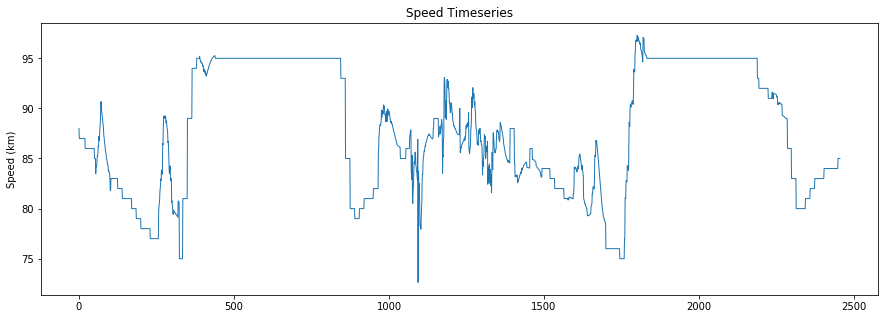

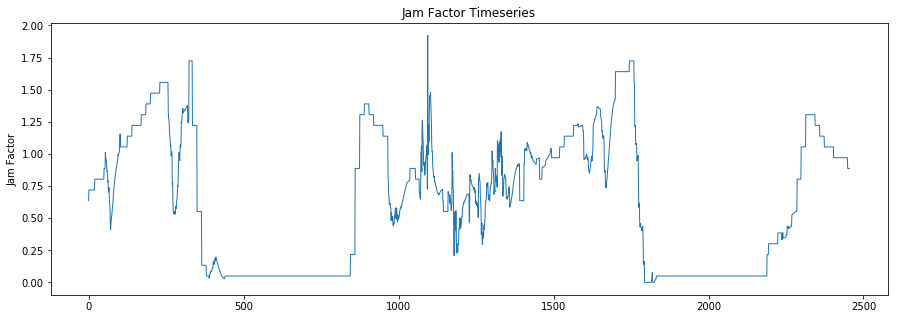

In [237]:
import matplotlib.pyplot as plt

#Gore Highway -Brookstead / Yandillaa

timeseries_GoreHwy = pd.read_csv('livelinks_36283.csv ') 
#frequency
#timeseries_GoreHwy.hist('speed', bins= 5)
jamf = timeseries_GoreHwy['jamf']
speed = timeseries_GoreHwy['speed']


# jamf = jamf.set_index('time') #set index
#here_links_rel_col_timeseries = here_links_rel_col.set_index('DATE-TIME') #set index

#speed.plot()
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(speed, linestyle='-', linewidth=1, label='Weekdays')
#ax.axhline(y=80, color='r', linestyle='-', linewidth=0.4)
ax.set_ylabel('Speed (km)')
ax.title.set_text('Speed Timeseries')

#jamf.plot()
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(jamf, linestyle='-', linewidth=1, label='Weekdays')
ax.set_ylabel('Jam Factor')
ax.title.set_text('Jam Factor Timeseries')

### Inverse relationship of variables speed and jam factor from here
Notice: Speed of 75 km at 22.51 also drops to 80km at 8am, Jam factor of 1.7 and 1.50 respectfully

View Plot - file:///C:/Users/jaworra/PycharmProjects/here_analysis/hypothesis2-timeseries.html

### Conclusion:
##### Non linear relationship between aadt sites from TMR and HERE samples (penetration rates ranges from 0 - 1.4% and ranking differences).


#### Below code for automation, API integration with HERE and QLD traffic.

In [144]:
#Set session proxies
import requests
import time
import pandas as pd

session = requests.Session()  # think of this as a new browser tab
session.proxies = {
    'http': 'localhost:3128',
    'https': 'localhost:3128'
}

#Lytton Rd at MowbrayPark inbound
#lat_MowbrayPark_inbound = -27.479528
#long_MowbrayPark_inbound= 153.045357
      
#Lytton Rd at MowbrayPark outbound
#lat_MowbrayPark_outbound=-27.479416
#long_MowbrayPark_outbound=153.045345

#incidentId ='Lytton road - MowbrayPark inbound'
#incidentCord = str(lat_MowbrayPark_inbound) + "," + str(long_MowbrayPark_inbound)
#incidentId ='Logan Mtwy'
#incidentCord = '-27.633742,152.964568'

incidentId ='Millmerran'
incidentCord = '-27.977373,151.088065'

# #setup dataframe
dfcols = ['id','linkId','name','avSpeed','jamF','cords']
dfHere = pd.DataFrame(columns = dfcols)

#configure session request API
starttime = time.time()
urlsession = requests.session()
prox = "0.0001"# "20" #proximity in metres 

#configure payload
url = "https://traffic.api.here.com/traffic/6.2/flow.json?app_id=" + app_id + "&app_code=" + app_code
url +="&prox="+incidentCord+",0.01&responseattributes=sh,fc&units=metric"

response = session.get(url)
response_json = response.json()
print(response_json)


if response !="": #only process return values

    #process json return for output
    try:
        r=response_json#json.loads(response)   
        for el1 in r['RWS']:
            for el2 in el1['RW']:
                    for el3 in el2['FIS']: #Road level
                        for el4 in el3['FI']: #flow information extract here at link level
                            linRd = el4['TMC'].get('DE').replace("'","") #get rid of ' i.e "O'keefe Street" to "Okeefe Street"
                            linRd_pk =el4['TMC'].get('PC')
                            #print(linRd)
                            flowInfoSpeed = el4['CF'][0].get('SU') #Speed (based on UNITS) not capped by speed limit
                            flowInfoJam = el4['CF'][0].get('JF') # The number between 0.0 and 10.0 indicating the expected quality of travel. When there is a road closure, the Jam Factor will be 10. As the number approaches 10.0 the quality of travel is getting worse. -1.0 indicates that a Jam Factor could not be calculated
                            flowInfoCon =  el4['CF'][0].get('CN') #Confidence, an indication of how the speed was determined. -1.0 road closed. 1.0=100% 0.7-100% Historical Usually a value between .7 and 1.0
                            for el5 in el4['SHP']: #get shape file
                                cordStr = changeCoordsStr(el5)
                                dfHere.loc[len(dfHere)] = [incidentId,linRd_pk,linRd, flowInfoSpeed,flowInfoJam,cordStr]
    except Exception as ex:
        print(str(response))
        raise ex       

{'RWS': [{'RW': [{'FIS': [{'FI': [{'TMC': {'PC': 36283, 'DE': 'Millmerran-Inglewood Road - Millmerran', 'QD': '+', 'LE': 30.67574}, 'SHP': [{'value': ['-27.96662,151.0066 -27.96661,151.00668 '], 'FC': 1}, {'value': ['-27.96661,151.00668 -27.96659,151.00691 -27.96657,151.00765 -27.96662,151.0084 '], 'FC': 1}, {'value': ['-27.96662,151.0084 -27.96669,151.00904 -27.96698,151.01112 '], 'FC': 1}, {'value': ['-27.96698,151.01112 -27.9671,151.012 -27.96718,151.0127 -27.96744,151.01454 -27.9677,151.01644 -27.96795,151.01836 -27.96819,151.02011 -27.96824,151.0205 '], 'FC': 1}, {'value': ['-27.96824,151.0205 -27.96836,151.02135 -27.96844,151.02199 '], 'FC': 1}, {'value': ['-27.96844,151.02199 -27.9685,151.02249 -27.96859,151.02313 -27.96877,151.0245 -27.96896,151.02588 -27.96915,151.0272 -27.96934,151.0287 -27.96973,151.0315 -27.9701,151.03428 '], 'FC': 1}, {'value': ['-27.9701,151.03428 -27.97032,151.0359 '], 'FC': 1}, {'value': ['-27.97032,151.0359 -27.97063,151.03825 '], 'FC': 1}, {'value': [

In [142]:
link_36283 = dfHere.loc[dfHere['linkId'] ==36283] 
speed = float(link_36283[0:1]['avSpeed'])
jamF= float(link_36283[0:1]['jamF'])
jamF

0.86408

In [154]:
    # #date = '20190419' #known holiday
    # #current date
import datetime
from datetime import date, timedelta
date=datetime.datetime.utcnow() + datetime.timedelta(hours=10)
date = date.strftime('%Y-%m-%d %H:%M')   
date

'2019-11-06 16:51'

In [116]:
gk= dfHere.groupby('linkId')

In [118]:
gk.first()

,id,name,avSpeed,jamF,cords
linkId,,,,,
36283,Millmerran,Millmerran-Inglewood Road - Millmerran,85.27,0.86408,"[[151.0066,-27.96662],[151.00668,-27.96661]]"
37843,Millmerran,Scrubby Creek Paddys Creek Road,88.00,0.64367,"[[151.26937,-27.87894],[151.26916,-27.87892]]"


In [70]:
response_json['RWS']

[{'RW': [{'FIS': [{'FI': [{'TMC': {'PC': 36283,
         'DE': 'Millmerran-Inglewood Road - Millmerran',
         'QD': '+',
         'LE': 30.67574},
        'SHP': [{'value': ['-27.96662,151.0066 -27.96661,151.00668 '],
          'FC': 1},
         {'value': ['-27.96661,151.00668 -27.96659,151.00691 -27.96657,151.00765 -27.96662,151.0084 '],
          'FC': 1},
         {'value': ['-27.96662,151.0084 -27.96669,151.00904 -27.96698,151.01112 '],
          'FC': 1},
         {'value': ['-27.96698,151.01112 -27.9671,151.012 -27.96718,151.0127 -27.96744,151.01454 -27.9677,151.01644 -27.96795,151.01836 -27.96819,151.02011 -27.96824,151.0205 '],
          'FC': 1},
         {'value': ['-27.96824,151.0205 -27.96836,151.02135 -27.96844,151.02199 '],
          'FC': 1},
         {'value': ['-27.96844,151.02199 -27.9685,151.02249 -27.96859,151.02313 -27.96877,151.0245 -27.96896,151.02588 -27.96915,151.0272 -27.96934,151.0287 -27.96973,151.0315 -27.9701,151.03428 '],
          'FC': 1},
        

In [71]:
response_json['RWS'][0]['RW']

[{'FIS': [{'FI': [{'TMC': {'PC': 36283,
       'DE': 'Millmerran-Inglewood Road - Millmerran',
       'QD': '+',
       'LE': 30.67574},
      'SHP': [{'value': ['-27.96662,151.0066 -27.96661,151.00668 '], 'FC': 1},
       {'value': ['-27.96661,151.00668 -27.96659,151.00691 -27.96657,151.00765 -27.96662,151.0084 '],
        'FC': 1},
       {'value': ['-27.96662,151.0084 -27.96669,151.00904 -27.96698,151.01112 '],
        'FC': 1},
       {'value': ['-27.96698,151.01112 -27.9671,151.012 -27.96718,151.0127 -27.96744,151.01454 -27.9677,151.01644 -27.96795,151.01836 -27.96819,151.02011 -27.96824,151.0205 '],
        'FC': 1},
       {'value': ['-27.96824,151.0205 -27.96836,151.02135 -27.96844,151.02199 '],
        'FC': 1},
       {'value': ['-27.96844,151.02199 -27.9685,151.02249 -27.96859,151.02313 -27.96877,151.0245 -27.96896,151.02588 -27.96915,151.0272 -27.96934,151.0287 -27.96973,151.0315 -27.9701,151.03428 '],
        'FC': 1},
       {'value': ['-27.9701,151.03428 -27.97032,151.03

In [95]:
dfHere.groupby(by='linkId')

In [96]:
test = dfHere.groupby(by='name')

In [110]:
gk= dfHere.groupby('linkId')

In [111]:
gk.first() 

,id,name,avSpeed,jamF,cords
linkId,,,,,
36283,Millmerran,Millmerran-Inglewood Road - Millmerran,85.27,0.86408,"[[151.0066,-27.96662],[151.00668,-27.96661]]"
37843,Millmerran,Scrubby Creek Paddys Creek Road,88.00,0.64367,"[[151.26937,-27.87894],[151.26916,-27.87892]]"


In [112]:
response_json['RWS'][0]['RW'][0]['FIS'][0]['FI'][0]['TMC']

{'PC': 36283,
 'DE': 'Millmerran-Inglewood Road - Millmerran',
 'QD': '+',
 'LE': 30.67574}

In [77]:
dfHere

,id,name,avSpeed,jamF,cords
0,Millmerran,Millmerran-Inglewood Road - Millmerran,86.21,0.78613,"[[151.0066,-27.96662],[151.00668,-27.96661]]"
1,Millmerran,Millmerran-Inglewood Road - Millmerran,86.21,0.78613,"[[151.00668,-27.96661],[151.00691,-27.96659],[..."
2,Millmerran,Millmerran-Inglewood Road - Millmerran,86.21,0.78613,"[[151.0084,-27.96662],[151.00904,-27.96669],[1..."
3,Millmerran,Millmerran-Inglewood Road - Millmerran,86.21,0.78613,"[[151.01112,-27.96698],[151.012,-27.9671],[151..."
4,Millmerran,Millmerran-Inglewood Road - Millmerran,86.21,0.78613,"[[151.0205,-27.96824],[151.02135,-27.96836],[1..."
5,Millmerran,Millmerran-Inglewood Road - Millmerran,86.21,0.78613,"[[151.02199,-27.96844],[151.02249,-27.9685],[1..."
6,Millmerran,Millmerran-Inglewood Road - Millmerran,86.21,0.78613,"[[151.03428,-27.9701],[151.0359,-27.97032]]"
7,Millmerran,Millmerran-Inglewood Road - Millmerran,86.21,0.78613,"[[151.0359,-27.97032],[151.03825,-27.97063]]"
8,Millmerran,Millmerran-Inglewood Road - Millmerran,86.21,0.78613,"[[151.03825,-27.97063],[151.04808,-27.97196]]"
9,Millmerran,Millmerran-Inglewood Road - Millmerran,86.21,0.78613,"[[151.04808,-27.97196],[151.05227,-27.97252]]"


In [79]:
            for el2 in el1['RW']:
                    for el3 in el2['FIS']: #Road level
                        for el4 in el3['FI']: #flow information extract here at link level
                            linRd = el4['TMC'].get('DE').replace("'","") #get rid of ' i.e "O'keefe Street" to "Okeefe Street"
                            #print(linRd)
                            flowInfoSpeed = el4['CF'][0].get('SU') #Speed (based on UNITS) not capped by speed limit
                            flowInfoJam = el4['CF'][0].get('JF') # The number between 0.0 and 10.0 indicating the expected quality of travel. When there is a road closure, the Jam Factor will be 10. As the number approaches 10.0 the quality of travel is getting worse. -1.0 indicates that a Jam Factor could not be calculated
                            flowInfoCon =  el4['CF'][0].get('CN') #Confidence, an indication of h